# Data Visualization and Prep

In [108]:
#References:
#https://www.kaggle.com/fppkaggle/making-tifs-look-normal-using-spectral-fork
#https://www.kaggle.com/ekami66/step-by-step-solution-with-keras-0-91-on-lb
#https://www.kaggle.com/fppkaggle/making-tifs-look-normal-using-spectral-fork


In [27]:
import os
import gc
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import spectral as sp
from sklearn.preprocessing import MinMaxScaler

In [28]:
# import spectral as sp
from skimage import io
from itertools import chain
from multiprocessing import Pool
from skimage.transform import resize, rotate

import bcolz
from bcolz_array_iterator import BcolzArrayIterator

import shutil
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm


In [109]:
path = 'input/PlanetAmazon'

In [30]:
train_tiff_dir, test_tiff_dir, train_csv_file, test_mapping_file = data_helper.get_tiff_data_files_paths(path)
labels_df = pd.read_csv(train_csv_file)
labels_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


# Indices:

In [31]:
def get_ndwi(img):
    '''Normalized difference water index'''
    #Input image with  NIR-R-G 
    # (GREEN - NIR) / (GREEN + NIR)
    ndwi = (img[:, :, 2] - img[:, :, 0]) / (img[:, :, 2] + img[:, :, 0]) 
    ndwi = ndwi[:,:,np.newaxis]
    
#     print('NDWI shape:{}'.format(ndwi.shape))
    return ndwi.astype(np.float32)

In [32]:
def get_evi(img):
    '''Enhanced Vegetation index'''
    #Input image with NIR-R-B channels.
    #Formula reference: Wikipedia: https://en.wikipedia.org/wiki/Enhanced_vegetation_index
    
    l=1; 
    c1 = 6.0 #6; 
    c2 = 1.0 #7.5;
#     c2 = 7.5
    g = 2.5
    
    evi = g * (img[:,:,0] - img[:,:,1])/(img[:,:,0]+ c1*img[:,:,1] - c2*img[:,:,2]+l)
    evi = evi[:,:,np.newaxis]
#     print('EVI shape:{}'.format(evi.shape))
    return evi.astype(np.float32)

# evi = get_evi(img4)


In [33]:
def get_savi(img):
    '''Soil Adjusted Vegetation Index'''
    #https://en.wikipedia.org/wiki/Soil-Adjusted_Vegetation_Index
    l = 0.5
    
    savi = (1+l)*((img[:,:,0] - img[:,:,1])/(img[:,:,0]+img[:,:,1]+l))
    savi = savi[:,:,np.newaxis]
#     print('SAVI shape:{}'.format(savi.shape))
    return savi.astype(np.float32)

# savi = get_savi(img4)

In [34]:
def get_msavi(img):
    
    # 2*NIR+1 - Sqrt((2*NIR+1)**2 - 8*(NIR-R))/2
    
    msavi = 2*img[:,:,0] + 1 - 0.5*np.sqrt((2*img[:,:,0] + 1)**2 - 8*(img[:,:,0] - img[:,:,1]))
    msavi = msavi[:,:,np.newaxis]
    return msavi.astype(np.float32)

In [35]:
def rescale_img(img):
    img = img[:,:,0]
    rescale_img = np.reshape(img, (-1, 1))
    scaler = MinMaxScaler(feature_range=(0,1))
    rescale_img = scaler.fit_transform(rescale_img)
    
    #Try changing the output shape to int64 or int 32:
    output = (np.reshape(rescale_img, img.shape)).astype(np.float32)
    return output#[:,:,np.newaxis]

In [36]:
def concat_channels(channels_list):
    #Concatenate
    concat = np.concatenate(channels_list,axis=2)
    
    #Sanity check:
#     print('Checking concat channels: ')
#     for i in range(channels_list[0].shape[2]):
#         print('channel {0} : {1}'.format(i,np.allclose(img[:,:,i] , concat[:,:,i])))
#         assert np.allclose(channels_list[0][:,:,i] , concat[:,:,i]) == True
    
    return concat

In [37]:
gc.collect()

11

In [102]:
#Get random image

img_list = os.listdir(train_tiff_dir)
random_idx = np.random.randint(0,len(img_list)-1,1)[0]
image_path = train_tiff_dir+'/'+img_list[random_idx]

jpg_image_path = train_tiff_dir[:-12]+'train-jpg'+'/'+img_list[random_idx][:-3]+'jpg'

# print(image_path)
# print(jpg_image_path)

In [103]:
# img = io.imread(image_path)
img = io.imread(image_path)
# img = rotate(img,-90)
# img = rotate(img,180)

img2 = sp.get_rgb(img, [2, 1, 0]) # RGB
img3 = sp.get_rgb(img, [3, 2, 1]) # NIR-R-G
img4 = sp.get_rgb(img, [3, 2, 0]) # NIR-R-B

In [104]:
#Creating matrices of gis indices
ndvi = (sp.ndvi(img, 2, 3))[:,:,np.newaxis].astype(np.float32)
ndwi = get_ndwi(img3)
evi = get_evi(img4)
savi = get_savi(img4)

In [105]:
ndvi.shape,ndwi.shape,evi.shape,savi.shape,img2.shape

((256, 256, 1), (256, 256, 1), (256, 256, 1), (256, 256, 1), (256, 256, 3))

In [106]:
#Rescaling for visualization:

jpg_img = io.imread(jpg_image_path)
ndvi = rescale_img(ndvi)
ndwi = rescale_img(ndwi)
evi = rescale_img(evi)
savi = rescale_img(savi)

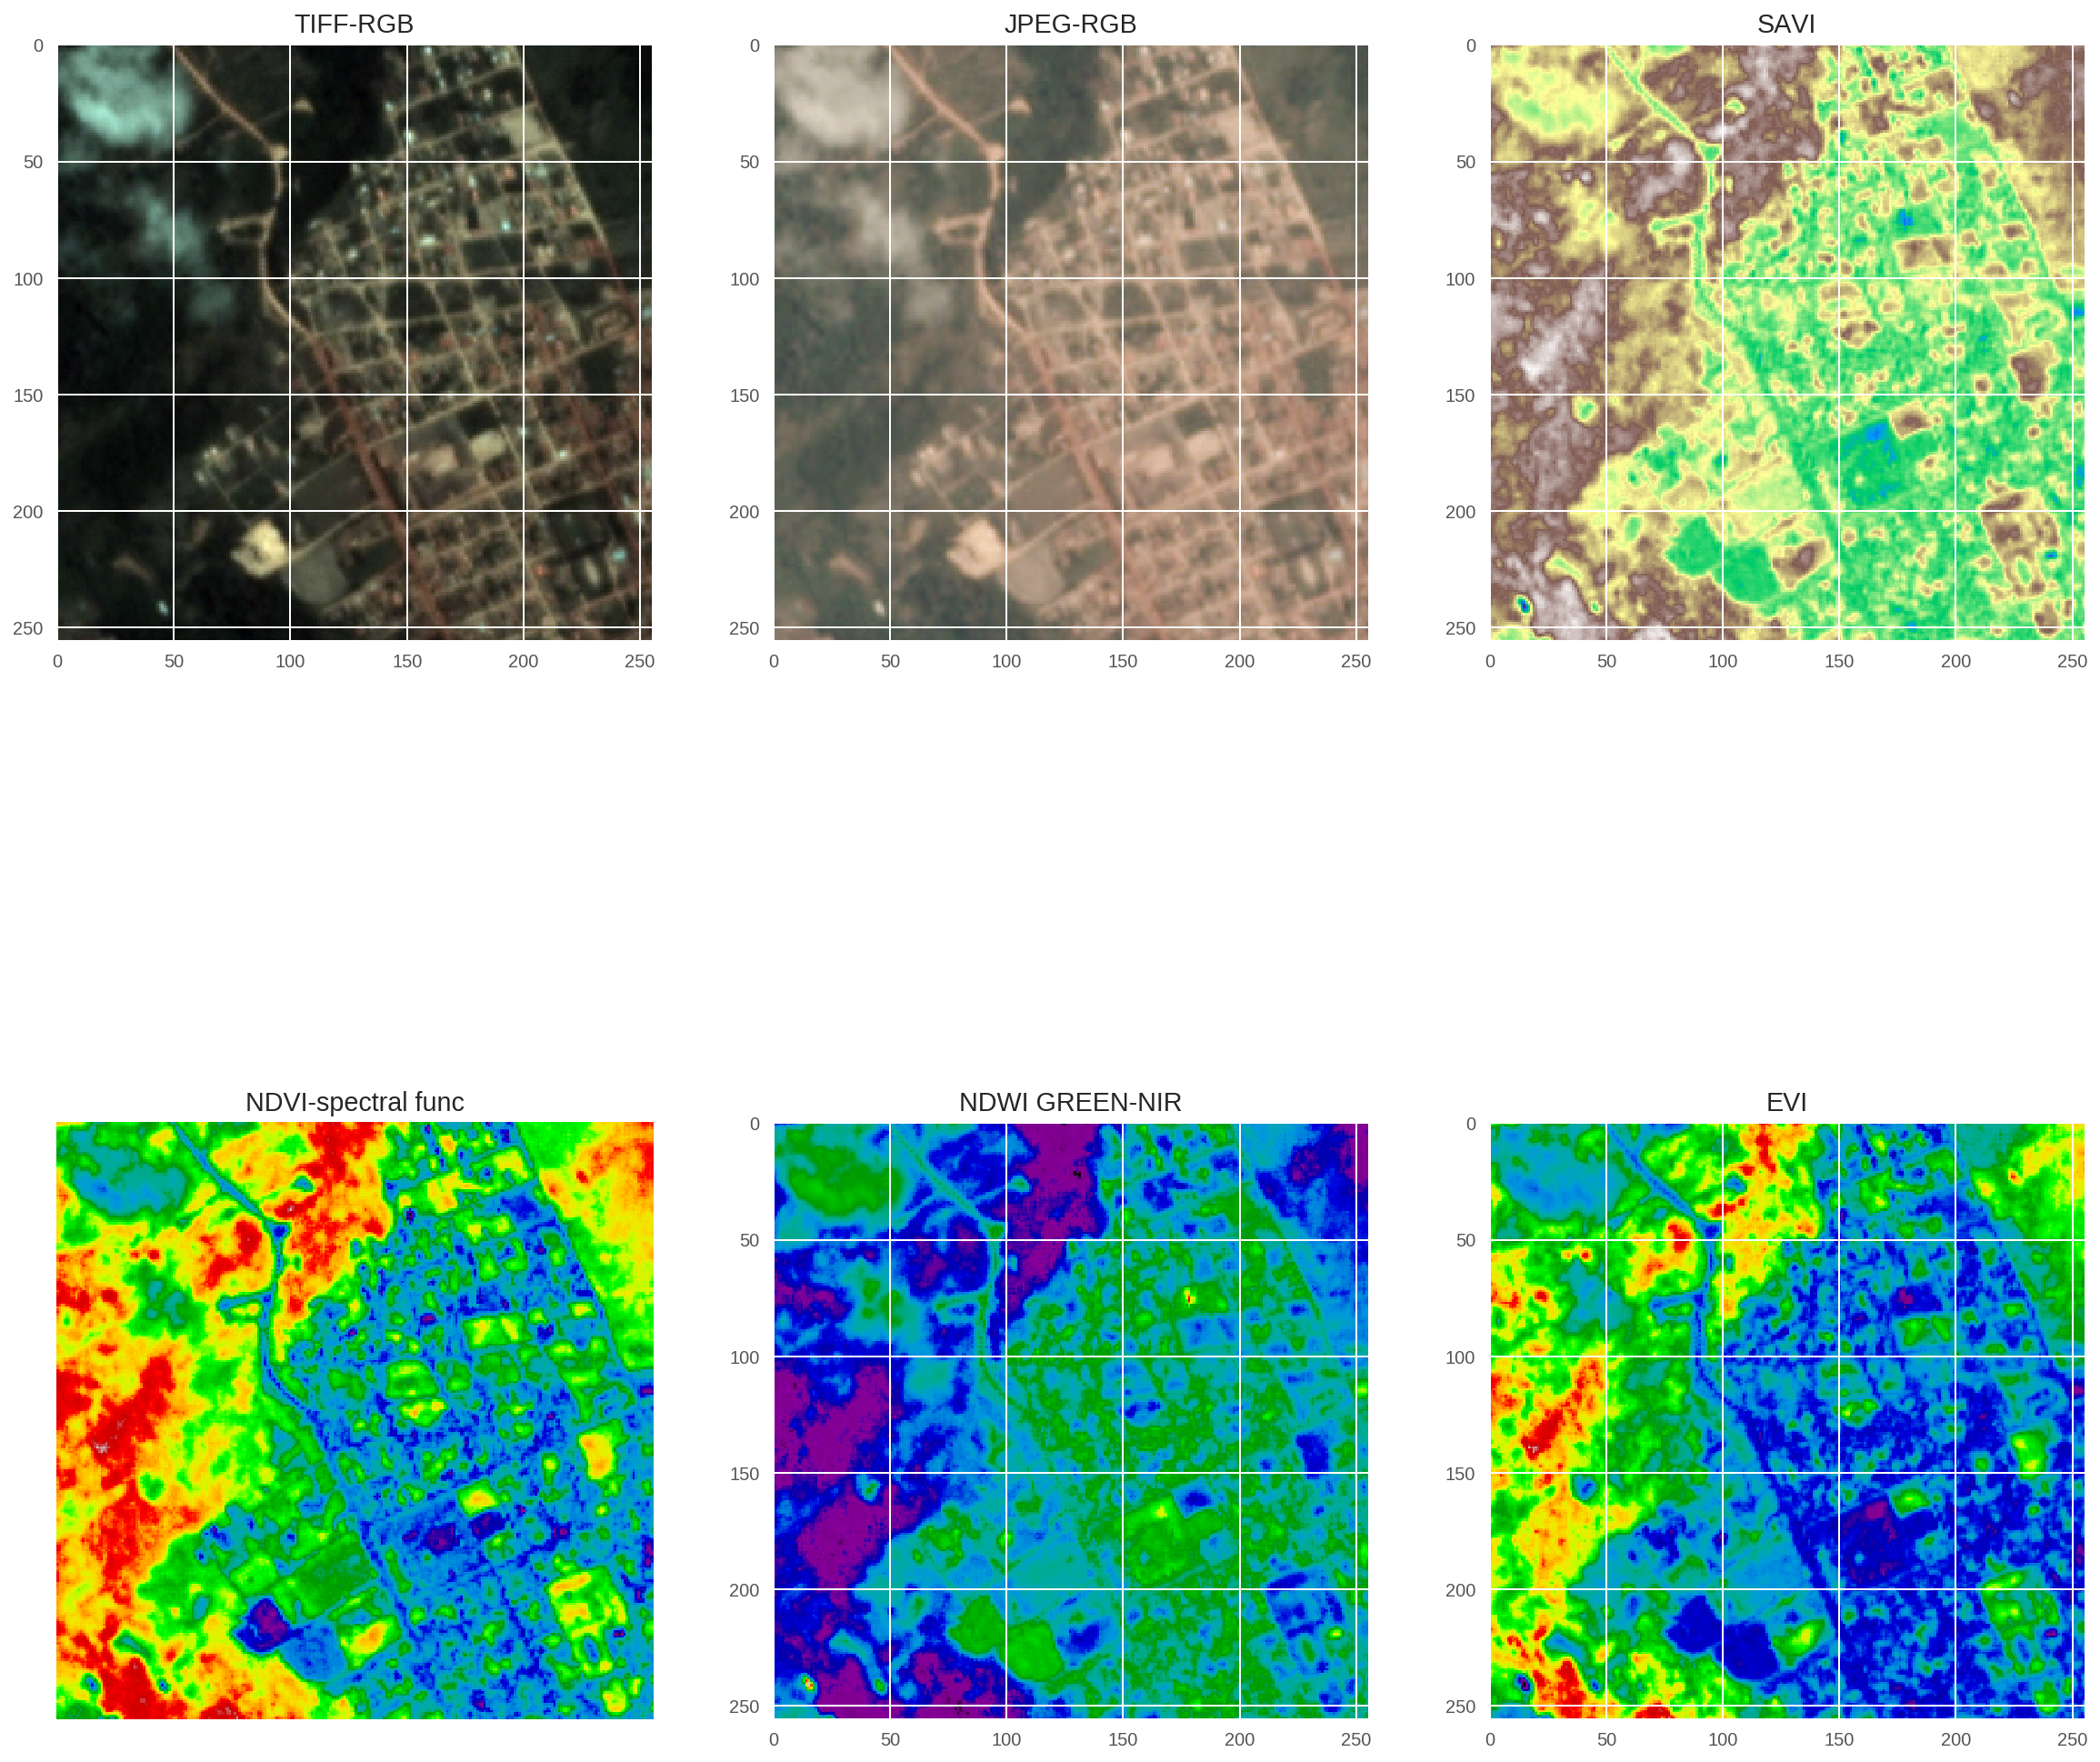

In [107]:
### Plots:

plt.style.use('ggplot')
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 20))
ax = axes.ravel()

ax[0] = plt.subplot(2, 3, 1, adjustable='box-forced')
ax[1] = plt.subplot(2, 3, 2, sharex=ax[0], sharey=ax[0], adjustable='box-forced')
ax[2] = plt.subplot(2, 3, 3, sharex=ax[0], sharey=ax[0], adjustable='box-forced')
ax[3] = plt.subplot(2, 3, 4, adjustable='box-forced')
ax[4] = plt.subplot(2, 3, 5, adjustable='box-forced')
ax[5] = plt.subplot(2, 3, 6, adjustable='box-forced')

ax[0].imshow(img2)  # , cmap=plt.cm.gray)
ax[0].set_title('TIFF-RGB')

ax[1].imshow(jpg_img)  # , cmap=plt.cm.gray)
ax[1].set_title('JPEG-RGB')

# alternative cmaps e.g. nipy_spectral, gist_earth, terrain
ax[2].imshow(savi,cmap=plt.get_cmap('terrain'))
ax[2].set_title('SAVI')

ax[3].imshow(ndvi, cmap=plt.get_cmap('nipy_spectral')) 
ax[3].set_title('NDVI-spectral func')

ax[3].axis('off')
ax[4].imshow(ndwi, cmap=plt.get_cmap('nipy_spectral'))  # , cmap=plt.cm.gray)
ax[4].set_title('NDWI GREEN-NIR')

ax[5].imshow(evi, cmap=plt.get_cmap('nipy_spectral'))  # , cmap=plt.cm.gray)
ax[5].set_title('EVI')

plt.show()


# Get train matrices:

In [95]:
IMG_RESIZE=(64,64)
SPLIT_SIZE = 0.2
BATCH_SIZE = 64
NB_CLASSES = 17

In [76]:
def train_transform_to_matrices(*args):

    file_path, tags, jpeg_path, labels_map, img_resize = list(args[0])

    img = io.imread(file_path)
    img = rotate(img,180)
        
    img = resize(img,output_shape=img_resize)
#         print('Resize shape : {0}'.format(img.shape))
        
    img2 = sp.get_rgb(img, [2, 1, 0]) # RGB
    img3 = sp.get_rgb(img, [3, 2, 1]) # NIR-R-G
    img4 = sp.get_rgb(img, [3, 2, 0]) # NIR-R-B
        
#Calculate ndvi using spectral:
    #https://www.kaggle.com/fppkaggle/making-tifs-look-normal-using-spectral-fork
        
    ndvi = (sp.ndvi(img, 2, 3))[:,:,np.newaxis].astype(np.float32)
    ndwi = get_ndwi(img3)
    evi = get_evi(img4)
    savi = get_savi(img4)
        
    
    targets = np.zeros(len(labels_map))
    
    for t in tags.split(' '):
        targets[labels_map[t]] = 1
    
    jpg_img = io.imread(jpeg_path)
    jpg = resize(jpg_img,output_shape=img_resize)
    
    img_array = np.concatenate([jpg,ndvi,ndwi,evi,savi],axis=2)
    return img_array, targets


In [62]:
def get_train_matrices(train_set_folder, train_csv_file, img_resize, process_count):

    labels_df = pd.read_csv(train_csv_file)
    labels = sorted(set(chain.from_iterable([tags.split(" ") for tags in labels_df['tags'].values])))
    labels_map = {l: i for i, l in enumerate(labels)}

    files_path = []
    jpegs_path = []
    tags_list = []
    for file_name, tags in labels_df.values:
        files_path.append('{0}/{1}'.format(train_set_folder, file_name)+'.tif')
        jpeg_folder = '/'.join(train_tiff_dir.split('/')[:-1])+'/train-jpg/'
        jpegs_path.append('{0}/{1}'.format(jpeg_folder, file_name)+'.jpg')
        tags_list.append(tags)

    x_train = []
    y_train = []
    # Multiprocess transformation, the map() function take a function as a 1st argument
    # and the argument to pass to it as the 2nd argument. These arguments are processed
    # asynchronously on threads defined by process_count and their results are stored in
    # the x_train and y_train lists
    with ThreadPoolExecutor(process_count) as pool:
        for img_array, targets in tqdm(pool.map(train_transform_to_matrices, 
                                                [(file_path, tag,jpeg_path,labels_map, img_resize)
                                                 for file_path, tag, jpeg_path in zip(files_path, tags_list,jpegs_path)]),
                                       total=len(files_path)):
            x_train.append(img_array)
            y_train.append(targets)

    return [np.array(x_train), np.array(y_train, dtype=np.uint8), {v: k for k, v in labels_map.items()}]


In [ ]:
IMG_RESIZE = (128,128)

In [ ]:
x_train, y_train, y_map = get_train_matrices(train_tiff_dir,train_csv_file,img_resize=IMG_RESIZE,process_count=8)

## Test data processing:

### Fixing test image paths:

In [ ]:
BASEPATH = path+'/input'
WORKING = path+'/working'

CSVPATH = os.path.join(BASEPATH, 'test_v2_file_mapping.csv')
JPGPATH = os.path.join(BASEPATH, 'test-jpg-v2')
TIFPATH = os.path.join(BASEPATH, 'test-tif-v2')

FIXEDPATH = os.path.join(WORKING, 'fixed')

In [ ]:
def copy_and_rename(num_files=10):
    '''Copy up to `num_files` images to the scratch directory.
    `num_files` is needed because you can only write a few hundred
    megabytes in this kernel environment. Use the `df -h` command
    to check.
    
    This is a purposely non-destructive operation. You'll need to
    move the renamed files back to the test-tif-v2 directory so
    that your existing scripts will continue to work.
    '''
    n = 0

    if not os.path.exists(FIXEDPATH):
        os.mkdir(FIXEDPATH)

    for index, row in df.iterrows():
        old = os.path.join(TIFPATH, row['old'])
        new = os.path.join(FIXEDPATH, row['new'])
        shutil.copy(old, new)
        n += 1
        if n % 500 == 0:
            print('Copied {}'.format(n))
        # Remove the following lines to unleash the full power of
        # this kernel and copy & rename all the misnamed tif files!
        if n == num_files:
            print('Copied {} files as requested'.format(n))
            break
            
# df = pd.read_csv(CSVPATH)
# copy_and_rename(n_test)

### Transform test images to matrices:

In [ ]:
def test_transform_to_matrices(*args):
    """
    :param args: list of arguments
        test_set_folder: string
            The path of the all the test images
        file_name: string
            The name of the test image
        img_resize: tuple (int, int)
            The resize size of the original image given by the file_path argument
        :return: img_array, file_name
            img_array: Numpy array
                The image from the file_path as a numpy array resized with img_resize
            file_name: string
                The name of the test image
        """

    IMG_TYPE = '.tif'
        
    test_set_folder, file_name, img_resize = list(args[0])
    file_path = '{0}/{1}'.format(test_set_folder,file_name)
    jpeg_folder = '/'.join(train_tiff_dir.split('/')[:-1])+'/test-jpg'
    jpeg_path ='{0}/{1}'.format(jpeg_folder, file_name.split('.')[0])+'.jpg'
    
    img = io.imread(file_path)
    img = rotate(img,-90)
        
    img = resize(img,output_shape=img_resize)
#         print('Resize shape : {0}'.format(img.shape))
        
    img2 = sp.get_rgb(img, [2, 1, 0]) # RGB
    img3 = sp.get_rgb(img, [3, 2, 1]) # NIR-R-G
    img4 = sp.get_rgb(img, [3, 2, 0]) # NIR-R-B
        
#Calculate ndvi using spectral:
#https://www.kaggle.com/fppkaggle/making-tifs-look-normal-using-spectral-fork
        
#         img2_scaled = rescale_img(img2)
                
    #Indices:
    ndvi = (sp.ndvi(img, 2, 3))[:,:,np.newaxis].astype(np.float32)
    ndwi = get_ndwi(img3)
    evi = get_evi(img4)
    savi = get_savi(img4)

    jpg_img = io.imread(jpeg_path)
    jpg = resize(jpg_img,output_shape=img_resize)
    
#     img_array = np.concatenate([jpg,ndw,evi],axis=2)
    img_array = jpg  
    return img_array, file_name



In [ ]:
def get_test_matrices(test_set_folder, img_resize, process_count):
    x_test = []
    x_test_filenames = []
    files_name = os.listdir(test_set_folder)
#     files_path = glob(test_set_folder+'/*')

    # Multiprocess transformation, the map() function take a function as a 1st argument
    # and the argument to pass to it as the 2nd argument. These arguments are processed
    # asynchronously on threads defined by process_count and their results are stored in
    # the x_test and x_test_filename lists
    with ThreadPoolExecutor(process_count) as pool:
        for img_array, file_name in tqdm(pool.map(test_transform_to_matrices,
                                                  [(test_set_folder, file_name, img_resize)
                                                   for file_name in files_name]),
                                         total=len(files_name)):
            x_test.append(img_array)
            x_test_filenames.append(file_name)
    return (np.array(x_test), x_test_filenames)

In [ ]:
x_test, x_test_filenames = get_test_matrices(test_tiff_dir,img_resize=IMG_RESIZE,process_count=16)